# Assignment 2 Matteo Breganni 869549

In [ ]:
import os
import numpy as np
from time import time
from scipy.io import wavfile as wav

import matplotlib.pyplot as plt
import IPython.display as ipd # Notebook only

# Classification tools
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# File management
from google.colab import drive
import tarfile
from shutil import copyfile

# Frequency analysis
from scipy.fft import fft, fftfreq, rfft, rfftfreq
from scipy.signal import spectrogram
from librosa.feature import melspectrogram, mfcc
from librosa.display import specshow

In [ ]:
# Link Google Drive account, transfer dataset, and extract files
drive.mount('/content/gdrive')
copyfile('gdrive/My Drive/recordings.tar', 'recordings.tar')
tar = tarfile.open('recordings.tar')
tar.extractall()
tar.close()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
sound_rate, sound_data = wav.read('recordings/0_jackson_0.wav') # File read

In [ ]:
ipd.Audio(sound_data, rate=sound_rate) # Reproduce audio

# Data representation

## Temporal representation

In [ ]:
# Convert sample index into the corresponding timestamp, for the plot x-axis
sound_time = np.arange(sound_data.shape[0])*1.0/sound_rate

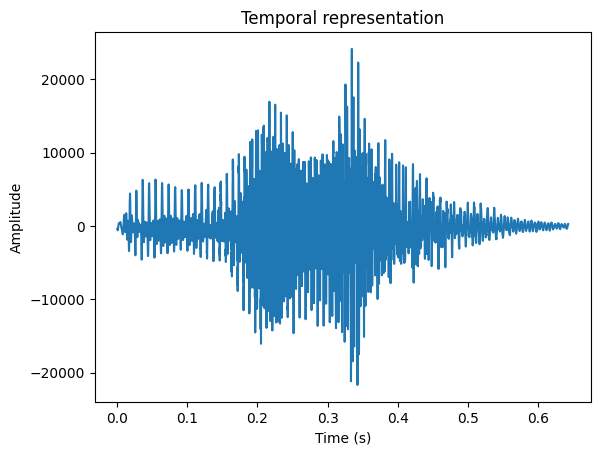

In [ ]:
# Visualizing a signal (temporal representation)
plt.plot(sound_time, sound_data);
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Temporal representation')
plt.show()

## Frequency representation (rftt)

In [ ]:
sound_rfft = rfft(sound_data)
sound_rfreqs = rfftfreq(len(sound_data), 1.0/sound_rate)
sound_rfft.shape

(2575,)

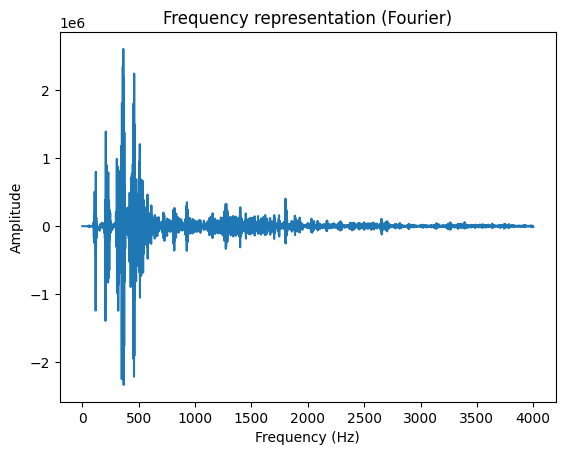

In [ ]:
# Visualizing the frequency signal
plt.plot(sound_rfreqs, np.real(sound_rfft));
plt.xlabel('Frequency (Hz)');
plt.ylabel('Amplitude')
plt.title('Frequency representation (Fourier)')
plt.show()

## Temporal/Frequency representation (Spectrogram)


In [ ]:
# Calculate the spectrogram
[spec_freqs, spec_times, spec] = spectrogram(sound_data, fs=sound_rate)
spec.shape

(129, 22)

In [ ]:
spec

array([[1.9808378e+01, 1.3692830e+02, 3.0229150e+02, ..., 6.7291542e+01,
        1.2496071e+01, 1.3940848e-01],
       [1.3429175e+02, 1.0398210e+02, 9.2873299e+01, ..., 1.2777069e+01,
        1.3902266e+01, 2.3013549e+00],
       [2.7365649e+02, 5.7476575e+02, 6.3436639e+02, ..., 1.2993532e+02,
        1.8718336e+01, 1.2659108e+01],
       ...,
       [5.4146640e-02, 9.5675385e-01, 6.1074656e-01, ..., 4.6955809e-02,
        7.2985627e-02, 8.8506816e-03],
       [1.2255514e-02, 6.1917758e-01, 5.4961842e-01, ..., 4.0482584e-02,
        1.5278501e-04, 3.6314536e-02],
       [2.2429220e-02, 8.9101815e-01, 3.4673753e-01, ..., 3.2173947e-03,
        8.6288974e-03, 7.3638684e-03]], dtype=float32)

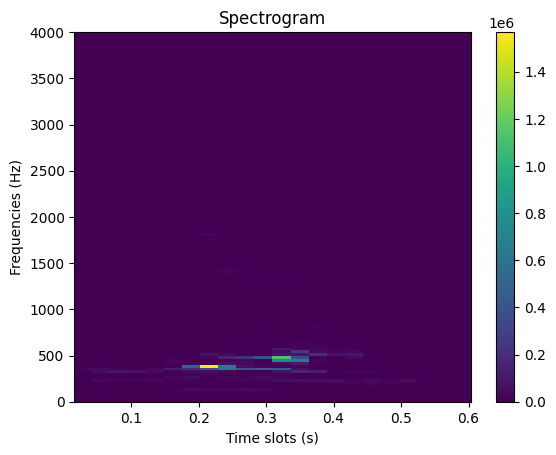

In [ ]:
# Spectrogram visualization
plt.imshow(spec, extent=[spec_times[0], spec_times[-1], spec_freqs[0], spec_freqs[-1]], origin='lower', aspect='auto', interpolation='nearest')
plt.xlabel('Time slots (s)')
plt.ylabel('Frequencies (Hz)')
plt.title('Spectrogram')
plt.colorbar()
plt.show()

## Temporal/Frequency representation (Mel Spectrogram)

In [ ]:
# Mel spectrogram computation (with default parameters)
mel = melspectrogram(y=sound_data*1.0, sr=sound_rate)
mel.shape

(128, 11)

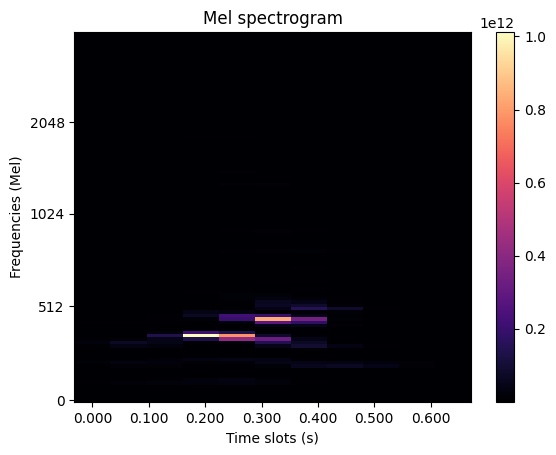

In [ ]:
# Mel spectrogram visualization (with librosa)
specshow(mel, x_axis='time', y_axis='mel', sr=sound_rate)
plt.xlabel('Time slots (s)')
plt.ylabel('Frequencies (Mel)')
plt.title('Mel spectrogram')
plt.colorbar()
plt.show()

## Cepstral representation (MFCC)

In [ ]:
mfccs = mfcc(y=sound_data*1.0, sr=sound_rate)
mfccs.shape

(20, 11)

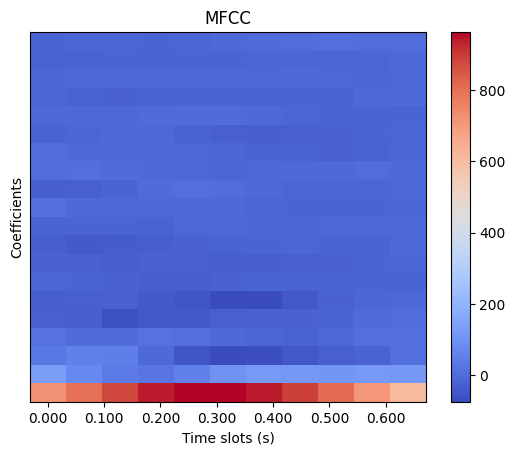

In [ ]:
# Visualization via librosa's specshow
specshow(mfccs, sr=sound_rate, x_axis='time')
plt.xlabel('Time slots (s)')
plt.ylabel('Coefficients')
plt.title('MFCC')
plt.colorbar()
plt.show()

# Classification

## Data loading

In [ ]:
# Placecholder for feature extractor
def identity(input):
    return input

# Data loader
def load_data(feature_extractor=identity, normalize=False):

    labels = []
    features = []

    for f in sorted(os.listdir('./recordings')):
        if f.endswith('.wav'):
            # Load file and compute the requested features
            _, signal = wav.read('./recordings/' + f)
            cur_features = feature_extractor(signal)
            features.append(cur_features)

            # Classes
            label = f.split('_')[0]
            labels.append(label)

    # X: features, y: labels
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=1)

    if normalize:
        eps = 0.001
        X_train = np.array(X_train)
        X_train_mean = X_train.mean(axis=0)
        X_train_std = X_train.std(axis=0)
        X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
        X_train = [row for row in X_train]

        X_test = [row for row in (np.array(X_test) - X_train_mean + eps)/(X_train_std + eps)]

    return X_train, X_test, y_train, y_test

## Frequency features (Fourier)

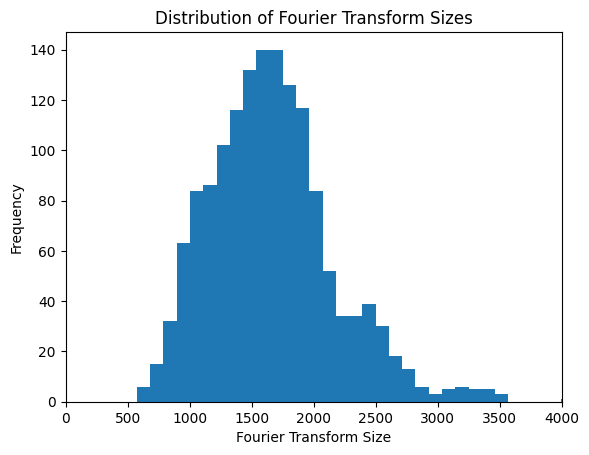

In [ ]:
ft_sizes = []

for f in sorted(os.listdir('./recordings')):
  if f.endswith('.wav'):
    _, signal = wav.read('./recordings/' + f)
    ft_sizes.append(len(np.real(rfft(signal))))

# Plot the distribution of the Fourier sizes
plt.hist(ft_sizes, bins='auto')
plt.title('Distribution of Fourier Transform Sizes')
plt.xlabel('Fourier Transform Size')
plt.ylabel('Frequency')
plt.xlim(0, 4000) # Reduced to not see outliers
plt.show()

In [ ]:
def feats_fourier(input, size=2500):  # Edited from the class, from 1000 to 2000, from information gathered in the previous plot
    input_ft = np.real(rfft(input))
    # Remove any values exceeding the given limit
    output = input_ft[0:min(size, input_ft.shape[0])]
    # Add null values (padding) in order to reach the requested size
    output = np.concatenate((output, np.zeros(size-output.shape[0])))
    return output

In [ ]:
# Data loading
X_train, X_test, y_train, y_test = load_data(feature_extractor=feats_fourier, normalize=True)

In [ ]:
# Verify the shape of extracted features
X_train[0].shape

(2500,)

In [ ]:
# Parameters to be tested in cross-validation
param_grid = {'C': [10, 15, 25, 30],
          'gamma': [0.01, 0.1, 0.5], }

# Support Vector Machine initialization
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# Training
t0 = time()
clf = clf.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))

Training completed in 50.336s


In [ ]:
# Result of the cross validation for parameters selection
print('Best parameters combination:')
print(' C: '+str(clf.best_estimator_.C))
print(' gamma: '+str(clf.best_estimator_.gamma))

Best parameters combination:
 C: 10
 gamma: 0.1


In [ ]:
# SVM test
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.06      0.11        17
           1       0.20      0.10      0.13        10
           2       0.00      0.00      0.00        15
           3       1.00      0.21      0.35        19
           4       0.05      0.09      0.06        11
           5       0.00      0.00      0.00        14
           6       0.10      0.79      0.18        14
           7       0.00      0.00      0.00        19
           8       0.00      0.00      0.00        17
           9       0.00      0.00      0.00        14

    accuracy                           0.12       150
   macro avg       0.23      0.12      0.08       150
weighted avg       0.27      0.12      0.09       150



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion matrix:


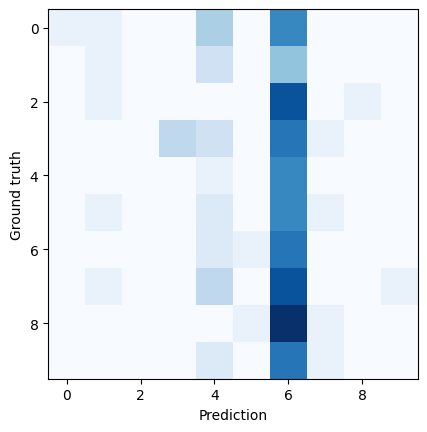

In [ ]:
# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues);
plt.xlabel('Prediction');
plt.ylabel('Ground truth');

In [ ]:
# These results were unexpected, I thought the bad results came from the early truncation,
# but with a higher truncation that makes more sense for this data (I tried 1500, 2000, 25000)
# the model is even worse, and even trying to optimize the hyperparameters didn't help much.
# This is probably just an indication that the feature is a terrible predictor

##Temporal/Frequency features (spectrogram)

In [ ]:
def feats_spectrogram(signal, rate=8000, tsize=10):
  _, _, spec = spectrogram(signal, fs=rate)  # Calculates the spectrogram

  # There is no need to check the frequencies axis since they are all up to 4000Hz, because the sound rate is 8000Hz (there's a theorem about it, and the noise impacts it too, I made sure the theory made sense before skipping this step)
  if spec.shape[1] < tsize: # Checks if the time axis is longer or shorter than tsize.
    spec_resized = np.pad(spec, ((0, 0), (0, tsize - spec.shape[1])), mode='constant') # Fill with zeros along the time axis until tsize
  else:
    spec_resized = spec[:, :tsize]  # Cut to the excess data until tsize

  output = spec_resized.flatten() # Unroll the spectrogram matrix into an array

  return output

In [ ]:
# Data loading
X_train, X_test, y_train, y_test = load_data(feature_extractor=feats_spectrogram, normalize=True)
X_train[0].shape

(1290,)

In [ ]:
# Parameters to be tested in cross-validation
param_grid = {'C': [100, 500, 1000],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

# Support Vector Machine initialization
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# Training
t0 = time()
clf = clf.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))

Training completed in 26.662s


In [ ]:
# Result of the cross validation for parameters selection
print('Best parameters combination:')
print(' C: '+str(clf.best_estimator_.C))
print(' gamma: '+str(clf.best_estimator_.gamma))

Best parameters combination:
 C: 1000
 gamma: 0.005


In [ ]:
# SVM test
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.59      0.69        17
           1       0.58      0.70      0.64        10
           2       0.77      0.67      0.71        15
           3       0.65      0.58      0.61        19
           4       0.30      0.27      0.29        11
           5       0.75      0.64      0.69        14
           6       0.18      0.64      0.28        14
           7       0.67      0.32      0.43        19
           8       0.80      0.24      0.36        17
           9       0.67      0.43      0.52        14

    accuracy                           0.50       150
   macro avg       0.62      0.51      0.52       150
weighted avg       0.64      0.50      0.53       150



Confusion matrix:


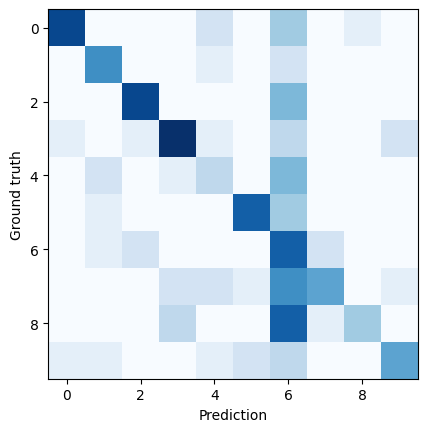

In [ ]:
# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues);
plt.xlabel('Prediction');
plt.ylabel('Ground truth');

In [ ]:
# The results are exactly the same as the example provided. It's interesting how the precision for "6" is so low, much lower than the others, but I haven't been able to come up with a good explanation for it

##Cepstral features (MFCC)

In [ ]:
def feats_mfcc(signal, rate=8000, tsize=10):
  mfcc_features = mfcc(y=signal * 1.0, sr=rate) # Calculates the MFCC

  if mfcc_features.shape[1] < tsize:  # Checks if the time axis is longer or shorter than tsize.
    mfcc_resized = np.pad(mfcc_features, ((0, 0), (0, tsize - mfcc_features.shape[1])), mode='constant')  # Fill with zeros along the time axis until tsize
  else:
    mfcc_resized = mfcc_features[:, :tsize] # Cut to the excess data until tsize

  output = mfcc_resized.flatten() # Unroll the spectrogram matrix into an array

  return output

In [ ]:
# Data loading
X_train, X_test, y_train, y_test = load_data(feature_extractor=feats_mfcc, normalize=True)
X_train[0].shape


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2033
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1963
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2007
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1976
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1987
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1886
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py

(200,)

In [ ]:
# Parameters to be tested in cross-validation
param_grid = {'C': [100, 500, 1000],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

# Support Vector Machine initialization
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# Training
t0 = time()
clf = clf.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))

Training completed in 6.077s


In [ ]:
# Result of the cross validation for parameters selection
print('Best parameters combination:')
print(' C: '+str(clf.best_estimator_.C))
print(' gamma: '+str(clf.best_estimator_.gamma))

Best parameters combination:
 C: 100
 gamma: 0.005


In [ ]:
# SVM test
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        15
           3       1.00      1.00      1.00        19
           4       1.00      1.00      1.00        11
           5       1.00      1.00      1.00        14
           6       1.00      1.00      1.00        14
           7       1.00      0.95      0.97        19
           8       1.00      1.00      1.00        17
           9       0.93      1.00      0.97        14

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150



Confusion matrix:


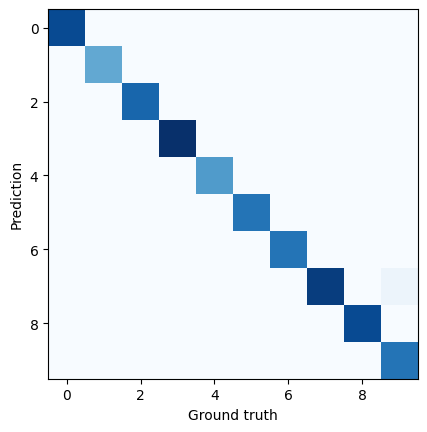

In [ ]:
# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues);
plt.xlabel('Ground truth');
plt.ylabel('Prediction');

In [ ]:
# Edited function to avoid all the warnings from librosa
def feats_mfcc2(signal, rate=8000, tsize=10, n_fft=512):
  mfcc_features = mfcc(y=signal * 1.0, sr=rate, n_fft=n_fft) # Calculates the MFCC

  if mfcc_features.shape[1] < tsize:  # Checks if the time axis is longer or shorter than tsize.
    mfcc_resized = np.pad(mfcc_features, ((0, 0), (0, tsize - mfcc_features.shape[1])), mode='constant')  # Fill with zeros along the time axis until tsize
  else:
    mfcc_resized = mfcc_features[:, :tsize] # Cut to the excess data until tsize

  output = mfcc_resized.flatten() # Unroll the spectrogram matrix into an array

  return output

In [ ]:
# Data loading
X_train, X_test, y_train, y_test = load_data(feature_extractor=feats_mfcc2, normalize=True)
X_train[0].shape

(200,)

In [ ]:
# Parameters to be tested in cross-validation
param_grid = {'C': [100, 500, 1000],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

# Support Vector Machine initialization
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# Training
t0 = time()
clf = clf.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))

Training completed in 5.749s


In [ ]:
# Result of the cross validation for parameters selection
print('Best parameters combination:')
print(' C: '+str(clf.best_estimator_.C))
print(' gamma: '+str(clf.best_estimator_.gamma))

Best parameters combination:
 C: 100
 gamma: 0.005


In [ ]:
# SVM test
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        15
           3       1.00      1.00      1.00        19
           4       1.00      1.00      1.00        11
           5       1.00      1.00      1.00        14
           6       0.93      1.00      0.97        14
           7       1.00      0.95      0.97        19
           8       1.00      1.00      1.00        17
           9       1.00      1.00      1.00        14

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150



In [ ]:
mis_predictions = (y_pred != y_test).sum()

print(f"Number of mispredictions: {mis_predictions}")

Number of mispredictions: 1


Confusion matrix:


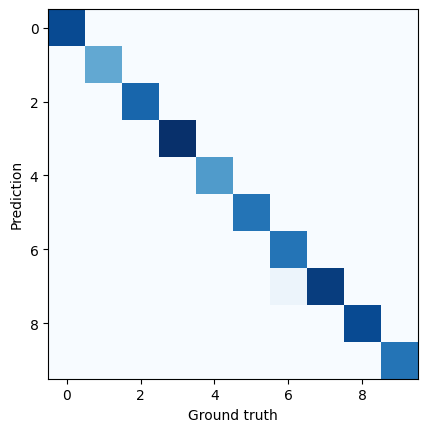

In [ ]:
# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues);
plt.xlabel('Ground truth');
plt.ylabel('Prediction');

In [ ]:
# The results reached with MFCC are great, almost perfect. In the second model there is only 1 misprediction, in 150 test samples, so the result is really great.
# It would be interesting to find out exactly which sample it is, to check if there's anything special about that audio clip

In [ ]:
# I added some code to the data loader to save the names of the files imported, so we can look for the mispredicted file
# Data loader
def load_data2(feature_extractor=identity, normalize=False):
    labels = []
    features = []
    filenames = []  # List to store filenames
    for f in sorted(os.listdir('./recordings')):
        if f.endswith('.wav'):
            # Load file and compute the requested features
            _, signal = wav.read('./recordings/' + f)
            cur_features = feature_extractor(signal)
            features.append(cur_features)
            # Store the filename
            filenames.append(f)
            # Classes
            label = f.split('_')[0]
            labels.append(label)
    # X: features, y: labels
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=1)
    if normalize:
        eps = 0.001
        X_train = np.array(X_train)
        X_train_mean = X_train.mean(axis=0)
        X_train_std = X_train.std(axis=0)
        X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
        X_train = [row for row in X_train]
        X_test = [row for row in (np.array(X_test) - X_train_mean + eps)/(X_train_std + eps)]
    return X_train, X_test, y_train, y_test, train_filenames, test_filenames, X_train_mean, X_train_std

# Data loading
X_train, X_test, y_train, y_test, train_filenames, test_filenames, X_train_mean, X_train_std = load_data2(feature_extractor=feats_mfcc2, normalize=True)

# no need to train another model

y_pred = clf.predict(X_test)

# Find the indices where predictions and true labels don't match
misprediction_indices = np.where(y_pred != y_test)[0]

# If there's only one misprediction, print its index and the associated filename
if len(misprediction_indices) == 1:
    mispredicted_index = misprediction_indices[0]
    print(f"Index of the misprediction: {mispredicted_index}")
    print(f"Filename of the misprediction: {test_filenames[mispredicted_index]}")
    print(f"True label: {y_test[mispredicted_index]}")
    print(f"Predicted label: {y_pred[mispredicted_index]}")
else:
    print(f"Indices of mispredictions: {misprediction_indices}")


Index of the misprediction: 55
Filename of the misprediction: 7_theo_35.wav
True label: 7
Predicted label: 6


In [ ]:
# This is the mispredicted file
sound_rate, sound_data = wav.read('recordings/7_theo_35.wav')
ipd.Audio(sound_data, rate=sound_rate)

In [ ]:
# More code just to make sure it's exactly that one
features2 = []
features = feats_mfcc2(sound_data)
features2.append(features)
normalized_features = (features2 - X_train_mean + 0.001) / (X_train_std + 0.001)
prediction2 = clf.predict(normalized_features)
prediction2[0]

'6'

In [ ]:
# To me it doesn't sound like there's anything special, by listening to the audio track, that would make it unexpectedly fail